In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda")

In [5]:
import os
import cv2 as cv

bus_path = '/home/hatcher/test/deep-learning/VehicleDataset/bus'
car_path = '/home/hatcher/test/deep-learning/VehicleDataset/car'
truck_path = '/home/hatcher/test/deep-learning/VehicleDataset/truck'
bus_pics = os.listdir(bus_path)
car_pics = os.listdir(car_path)
truck_pics = os.listdir(truck_path)
bus_list, car_list, truck_list = [], [], []

for bus_pic in bus_pics:
    img = cv.imread(bus_path+"/"+bus_pic)
    #将照片转为单通道的灰度图
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    img = cv.resize(img, (32, 32))
    flip_img = cv.flip(img, 1)
    equ_img = cv.equalizeHist(img)
    img = img/255
    bus_list.append(img)
    flip_img = flip_img/255
    bus_list.append(flip_img)
    equ_img = equ_img/255
    bus_list.append(equ_img)

for car_pic in car_pics:
    img = cv.imread(car_path+"/"+car_pic)
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    img = cv.resize(img, (32, 32))
    img = img/255
    car_list.append(img)

for truck_pic in truck_pics:
    img = cv.imread(truck_path+"/"+truck_pic)
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    img = cv.resize(img, (32, 32))
    flip_img = cv.flip(img, 1)
    img = img/255
    truck_list.append(img)
    flip_img = flip_img/255
    truck_list.append(flip_img)

bus_length = len(bus_list)
car_length = len(car_list)
truck_length = len(truck_list)
num_bus_train = int(len(bus_list)*0.8)
num_car_train = int(len(car_list)*0.8)
num_truck_train = int(len(truck_list)*0.8)
train_y,test_y=[],[]
for i in range(num_bus_train):
    #train_y.append([1,0,0,0,0,0,0,0,0,0])
    train_y.append([1,0,0])
for i in range(num_car_train):
    #train_y.append([0,1,0,0,0,0,0,0,0,0])
    train_y.append([0,1,0])
for i in range(num_truck_train):
    #train_y.append([0,0,1,0,0,0,0,0,0,0])
    train_y.append([0,0,1])
for i in range(num_bus_train,bus_length):
    #test_y.append([1,0,0,0,0,0,0,0,0,0])
    test_y.append([1,0,0])
for i in range(num_car_train,car_length):
    #test_y.append([0,1,0,0,0,0,0,0,0,0])
    test_y.append([0,1,0])
for i in range(num_truck_train,truck_length):
    #test_y.append([0,0,1,0,0,0,0,0,0,0])
    test_y.append([0,0,1])
train_x,test_x=[],[]
for i in range(num_bus_train):
    train_x.append(bus_list[i])
for i in range(num_car_train):
    train_x.append(car_list[i])
for i in range(num_truck_train):
    train_x.append(truck_list[i])
for i in range(num_bus_train,bus_length):
    test_x.append(bus_list[i])
for i in range(num_car_train,car_length):
    test_x.append(car_list[i])
for i in range(num_truck_train,truck_length):
    test_x.append(truck_list[i])

train_x = torch.Tensor(train_x)
test_x = torch.Tensor(test_x)
train_y = torch.Tensor(train_y)
test_y = torch.Tensor(test_y)
print("train_x:",train_x.size())
print("test_x:",test_x.size())
print("train_y:",train_y.size())
print("test_y:",test_y.size())
train_x = train_x[1:1701,:,:]
test_x = test_x[1:431,:,:]
train_y = train_y[1:1701,:]
test_y = test_y[1:431,:]
print("train_x:",train_x.size())
print("test_x:",test_x.size())
print("train_y:",train_y.size())
print("test_y:",test_y.size())

train_x: torch.Size([1722, 32, 32])
test_x: torch.Size([431, 32, 32])
train_y: torch.Size([1722, 3])
test_y: torch.Size([431, 3])
train_x: torch.Size([1700, 32, 32])
test_x: torch.Size([430, 32, 32])
train_y: torch.Size([1700, 3])
test_y: torch.Size([430, 3])


In [6]:
import torch.utils.data as Data
batch_size = 20# 将训练数据的特征和标签组合
train_dataset,test_dataset = Data.TensorDataset(train_x, train_y),Data.TensorDataset(test_x, test_y)
# 把 dataset 放入 DataLoader
train_iter = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
test_iter = Data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True,num_workers=2)

In [21]:
class ForwardNet(nn.Module):
    def __init__(self,pic_size=32):
        super(ForwardNet,self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(1024,2048),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(2048,4096),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(4096,1024),
            nn.Dropout(),
            nn.ReLU(inplace=True),            
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024,3)
        )
    def forward(self,x):
        y = self.flatten(x)
        y = self.linear(y)
        y = self.classifier(y)
        return y

In [8]:
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        #y_hat = y_hat.view(1,-1) 
        acc_sum += (y_hat.argmax(dim=1) == y.argmax(dim=1)).sum().item()
        l = loss(y_hat, y).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

In [9]:
def train(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    train_loss=[]
    test_loss=[]
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            y = y.to(device)
            #print(y.size())
            y_hat = net(X)
            y_hat = y_hat.squeeze()
            #y_hat = y_hat.view(1,-1) 
            #print(y_hat.size())
            l=loss(y_hat,y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params,lr)
            else:
                optimizer.step()
            train_l_sum+=l.item()
            '''print(y_hat.shape)
            print(y.shape)
            print(y_hat)
            print(y_hat.argmax(dim=1))
            print(y)
            print(y_hat.argmax(dim=1)==y)
            '''
            train_acc_sum+=(y_hat.argmax(dim=1)==y.argmax(dim=1)).sum().item()
            n+=y.shape[0]
        test_acc,test_l = evaluate_accuracy(test_iter,net,loss)
        train_loss.append(train_l_sum/n)
        test_loss.append(test_l)
        print('epoch%d,loss%.4f,train acc %3f,test acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,test_acc))
    return train_loss,test_loss

In [22]:
num_epochs=40
lr=0.03
loss=nn.CrossEntropyLoss()
net = ForwardNet()
net.to(device)
optimizer=torch.optim.SGD(net.parameters(),lr)
for params in net.parameters():
    nn.init.normal_(params,mean=0,std=0.01)

In [23]:
train_loss,test_loss=train(net,train_iter,test_iter,loss,num_epochs,batch_size,net.parameters(),lr,optimizer)

epoch1,loss0.0547,train acc 0.371176,test acc 0.363
epoch2,loss0.0540,train acc 0.397059,test acc 0.472
epoch3,loss0.0496,train acc 0.560588,test acc 0.595
epoch4,loss0.0366,train acc 0.704706,test acc 0.747
epoch5,loss0.0306,train acc 0.767647,test acc 0.812
epoch6,loss0.0252,train acc 0.818824,test acc 0.840
epoch7,loss0.0229,train acc 0.828235,test acc 0.819
epoch8,loss0.0213,train acc 0.845294,test acc 0.833
epoch9,loss0.0188,train acc 0.864706,test acc 0.833
epoch10,loss0.0189,train acc 0.865294,test acc 0.860
epoch11,loss0.0176,train acc 0.878235,test acc 0.867
epoch12,loss0.0167,train acc 0.887647,test acc 0.851
epoch13,loss0.0158,train acc 0.887647,test acc 0.877
epoch14,loss0.0149,train acc 0.895294,test acc 0.879
epoch15,loss0.0179,train acc 0.880000,test acc 0.863
epoch16,loss0.0163,train acc 0.886471,test acc 0.884
epoch17,loss0.0125,train acc 0.908824,test acc 0.895
epoch18,loss0.0136,train acc 0.904706,test acc 0.895
epoch19,loss0.0124,train acc 0.911176,test acc 0.898
ep

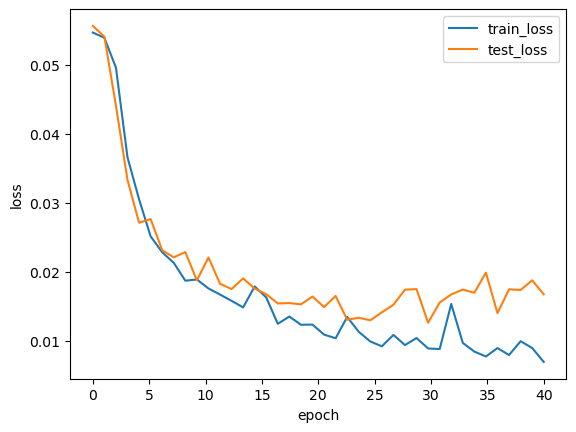

In [24]:
import matplotlib.pyplot as plt
import numpy as np
x=np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label='train_loss',linewidth=1.5)
plt.plot(x,test_loss,label='test_loss',linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()